In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
import cv2
import numpy as np
import rawpy
import imutils
from PIL import Image

import matplotlib.pyplot as plt

from photo.film import detect, show, crop, rotate, save, film_format

Image.MAX_IMAGE_PIXELS = None

# To dos
- Transform coordinates on subsampled image, rather than compute on full image


In [216]:
path = "/Users/dsuo/Downloads/2021-01-31-0003.tif"
fmt = "6x6"

DPI = 3200
working_dpi = 400
scaling = DPI // working_dpi

In [217]:
image = Image.open(path)
raw = np.array(image)
# raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# with rawpy.imread(path) as raw:
#     raw = raw.postprocess()

In [218]:
raw.shape

(31037, 18880, 3)

In [237]:
im = raw[::scaling, ::scaling, :]

In [238]:
im.shape

(3880, 2360, 3)

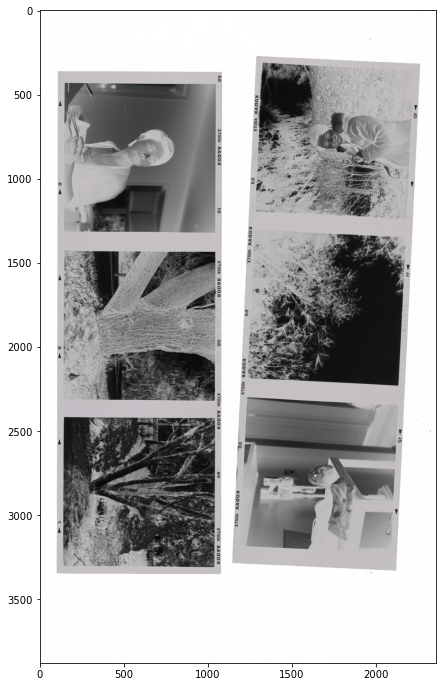

In [239]:
plt.figure(figsize=(16, 12))
plt.imshow(im)

Target width: 960.63, Target aspect ratio: 1.00
3879.0 2359.0
3018.354736328125 977.8440551757812
2.717533056531925
-87.28246694346807
2987.024658203125 978.1025390625
0.12640605352166115
-89.87359394647832


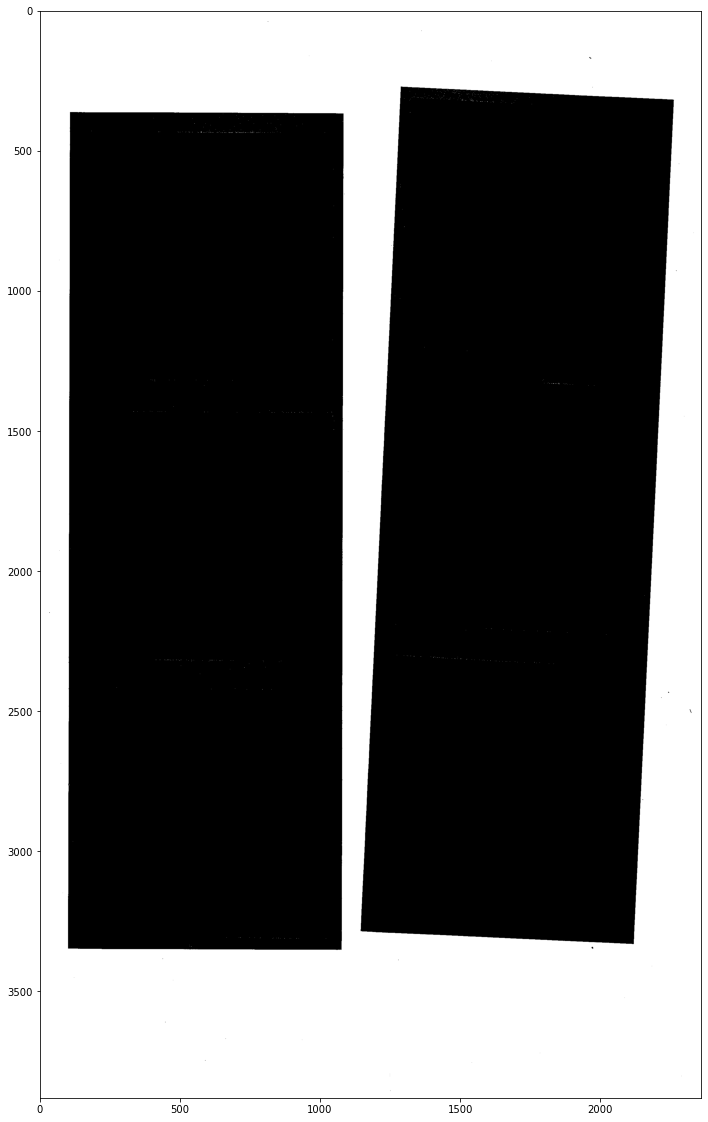

In [255]:
paths, rotations = detect(im,
                          fmt=fmt,
                          threshold=200,
                          dpi=working_dpi,
                          verbose=True,
                          use_tqdm=True
                         )

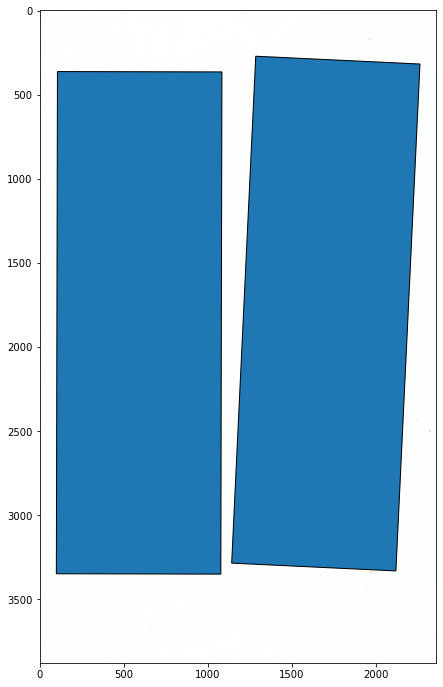

In [256]:
show(im, paths)

In [263]:
# dpi = working_dpi
# cropped = crop(im, paths, dpi=dpi)
dpi = DPI
cropped = crop(raw, [path * scaling for path in paths], dpi=dpi)

spacing = int(np.ceil(dpi  * (film_format[fmt]["spacing"] / 25.4)))
width = int(np.ceil(dpi * (film_format[fmt]["width"] / 25.4)))

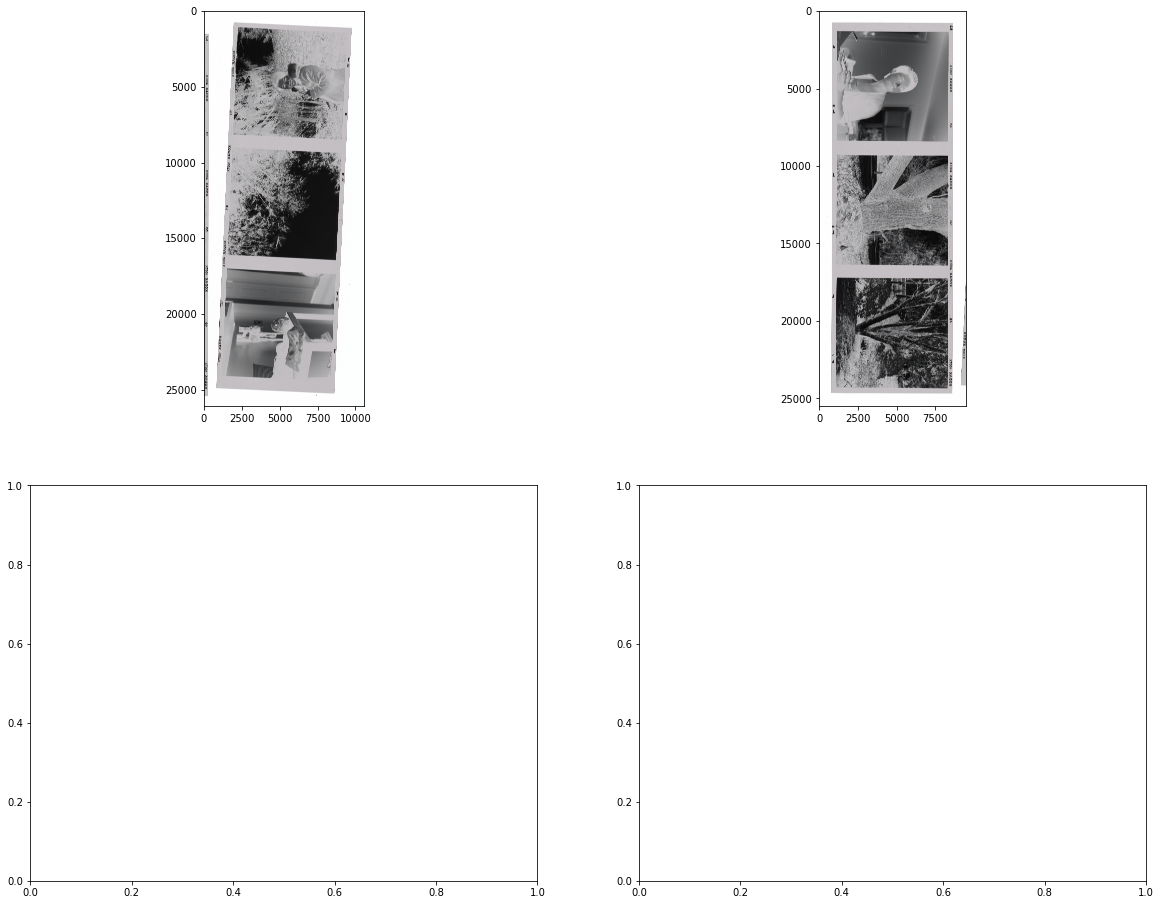

In [264]:
fig, axs = plt.subplots(len(cropped) // 2 + 1, 2, figsize=(20, 16))

for i, preview in enumerate(cropped):
    axs[i // 2, i % 2].imshow(preview, cmap="gray")

In [265]:
rotated = rotate(cropped, rotations)

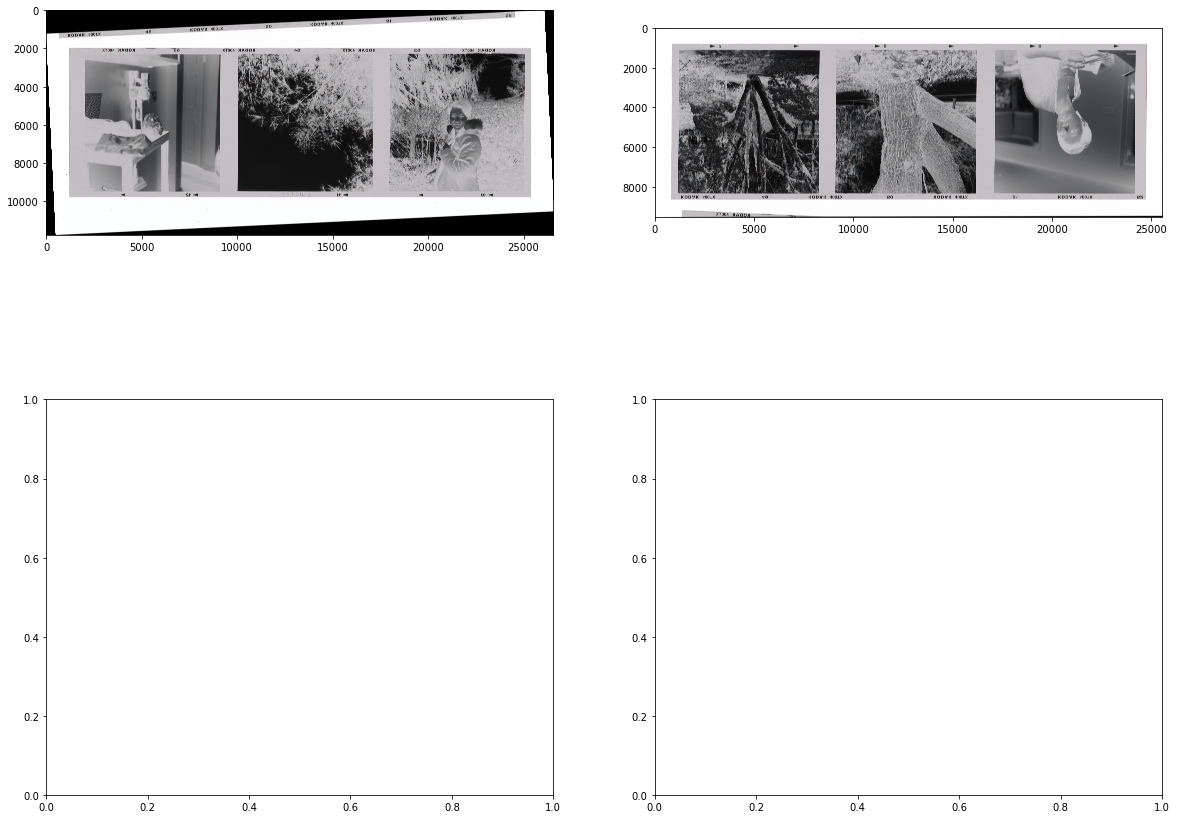

In [266]:
fig, axs = plt.subplots(len(rotated) // 2 + 1, 2, figsize=(20, 16))

for i, preview in enumerate(rotated):
    axs[i // 2, i % 2].imshow(preview, cmap="gray")

Target width: 7685.04, Target aspect ratio: 1.00
26090.435546875 10549.37890625
24135.0 7818.0
0.0
0.0
Target width: 7685.04, Target aspect ratio: 1.00
25513.404296875 9477.353515625
23882.99609375 7812.9990234375
0.0
0.0


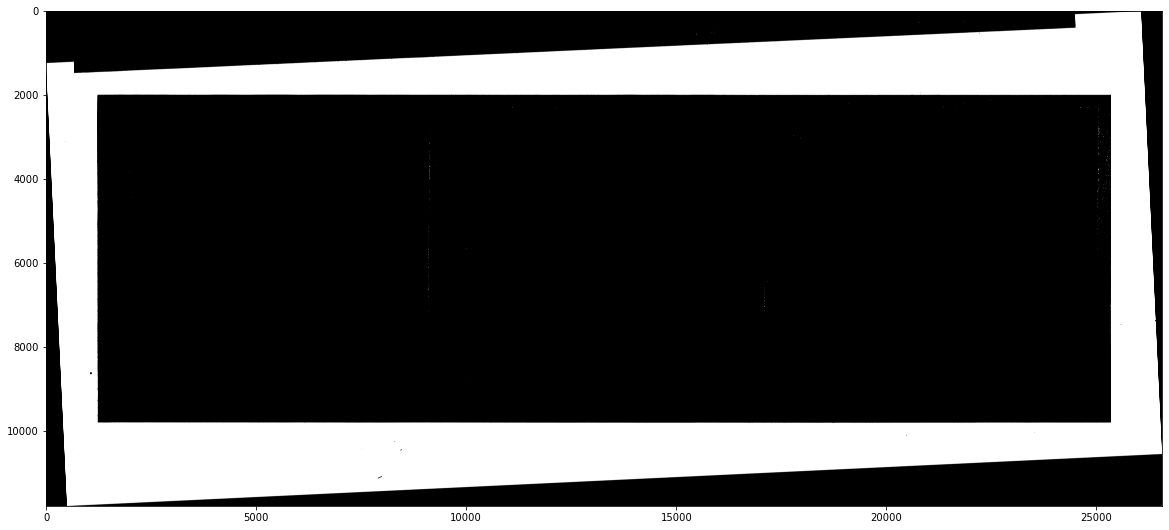

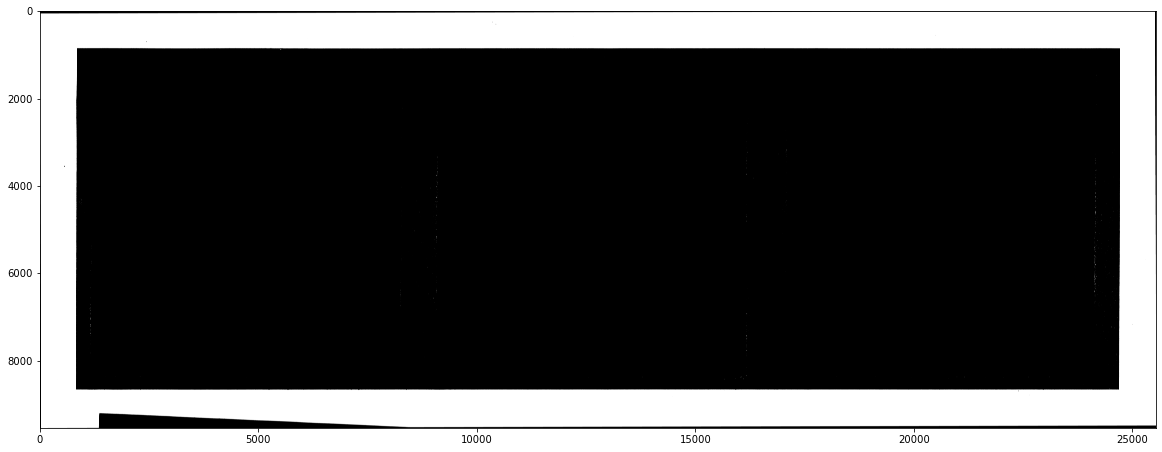

In [267]:
strips = []
for rotated_im in rotated:
    p, r = detect(rotated_im,
                          fmt=fmt,
                          threshold=200,
                          dpi=dpi,
                          verbose=True,
                          use_tqdm=True
                         )
    c = crop(rotated_im, p, pad=0.0, dpi=dpi)
    strips.append(c[0])

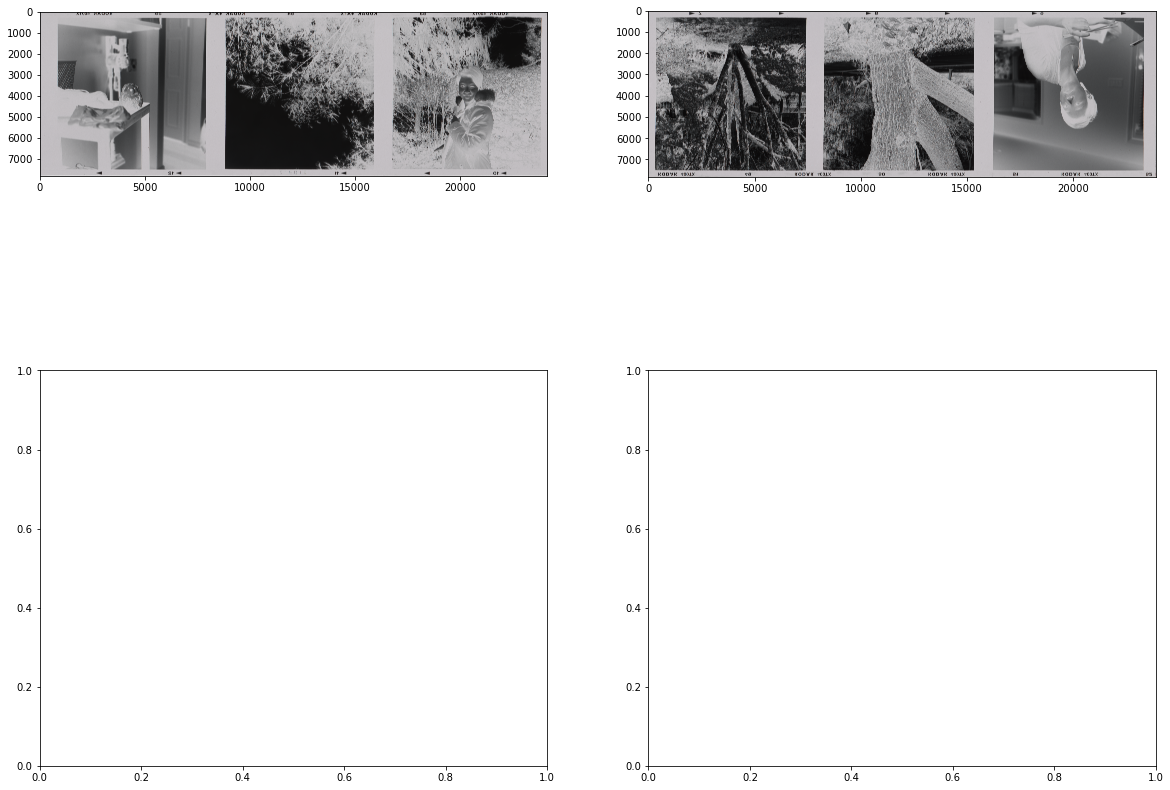

In [268]:
fig, axs = plt.subplots(len(strips) // 2 + 1, 2, figsize=(20, 16))

for i, strip in enumerate(strips):
    axs[i // 2, i % 2].imshow(strip, cmap="gray")

In [269]:
ims = []

for strip in strips:
    bw = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    ret, threshed = cv2.threshold(bw, 100, 255, cv2.THRESH_BINARY)
    islands = np.sum(threshed, axis=0) > (0.98 * threshed.shape[0]) * 255
    
    end = 0
    while end < threshed.shape[1]:
        candidates = np.where(islands[end:] == 0)
        if len(candidates) == 0 or len(candidates[0]) == 0:
            break
        start = max(0, candidates[0][0] - spacing // 2) + end
        end = min(start + width + spacing, threshed.shape[1])
        ims.append(strip[:, start:end, :])
        print(start, end, strip[:, start:end, :].shape)

397 8335 (7819, 7938, 3)
8360 16298 (7819, 7938, 3)
16314 24136 (7819, 7822, 3)
0 7938 (7813, 7938, 3)
7938 15876 (7813, 7938, 3)
15876 23814 (7813, 7938, 3)


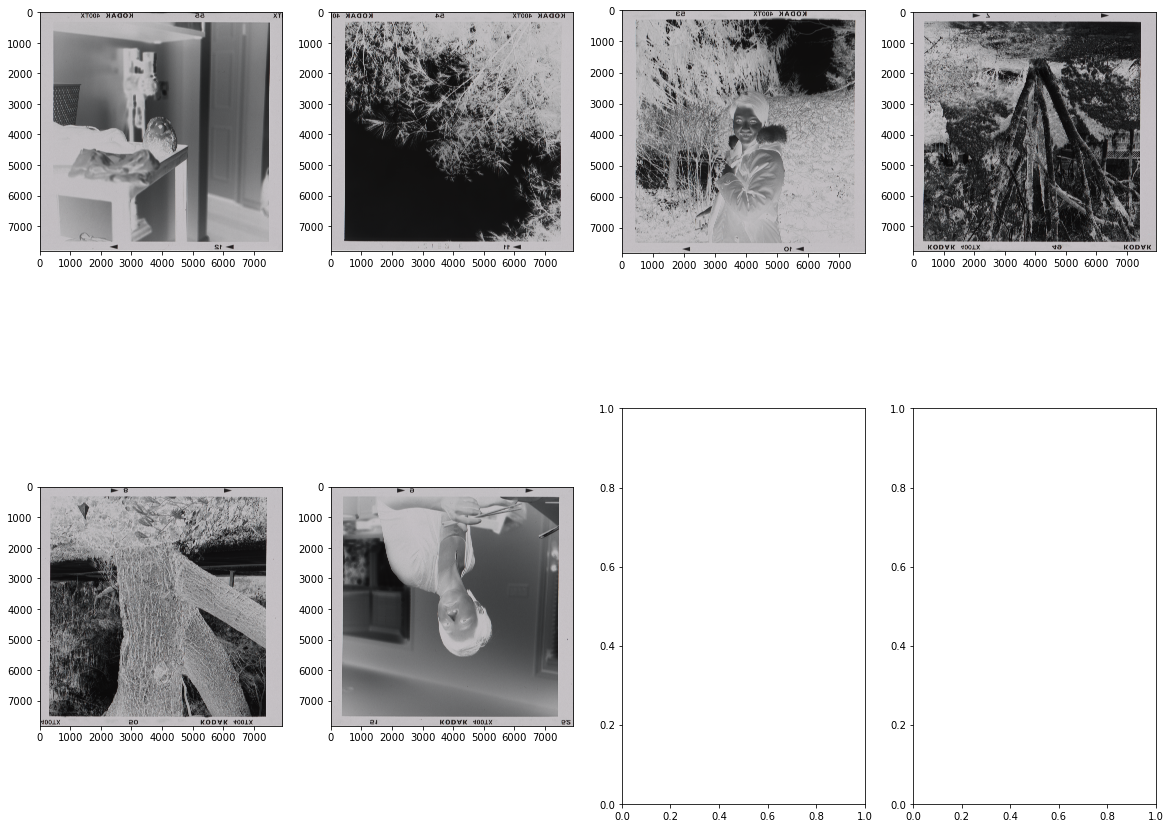

In [270]:
fig, axs = plt.subplots(len(ims) // 4 + 1, 4, figsize=(20, 16))

for i, im in enumerate(ims):
    axs[i // 4, i % 4].imshow(im, cmap="gray")

In [271]:
save(ims, "~/Downloads/test", format="tiff")